In [262]:
# import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import csv

In [263]:
# helper functions
def dollar_formatter(x, pos):
    return f'${x:,.0f}'

def adjust_for_inflation(df, inflation_dict, base_year=2025):
    """Adjust values to base year dollars using inflation rates."""
    df_adjusted = df.copy()
    df_adjusted['value'] = df_adjusted['value'].astype(float)  # convert to float

    
    for year in df_adjusted['year'].unique():
        cumulative_inflation = 1.0
        # Compound inflation from the year to base year
        for y in range(year, base_year):
            cumulative_inflation *= (1 + inflation_dict[str(y)])
        
        df_adjusted.loc[df_adjusted['year'] == year, 'value'] *= cumulative_inflation
    
    return df_adjusted


In [ ]:
# load the data frames and set up themes
pce_inflation_df = {"2025": 0.026, "2024": 0.027, "2023": 0.055, "2022": 0.063, "2021": 0.016, "2020": 0.018} # TODO: unhardcode the pce data
laf_fp_df = pd.read_csv("lafayette_financial_position_2020-2025.csv")
laf_act_df = pd.read_csv("lafayette_activities_2020-2025.csv")
laf_cf_df = pd.read_csv("lafayette_cash_flows_2020-2025.csv")

# colors
MAROON = '#822433'
GOLD = '#D19E15'
BROWN = '#8B4513'
GREY = '#A7A9AC'


# Assets & Liabilities Analysis

In [265]:
# preprocess to filter for assets and liabilities and sum by year
laf_assets_df = laf_fp_df[laf_fp_df['section'] == 'assets']
laf_annual_assets = laf_assets_df.groupby('year')['value'].sum().reset_index()

laf_liabilities_df = laf_fp_df[laf_fp_df['section'] == 'liabilities']
laf_annual_liabilities = laf_liabilities_df.groupby('year')['value'].sum().reset_index()

laf_annual_assets_adjusted = adjust_for_inflation(laf_annual_assets, pce_inflation_df)
laf_annual_liabilities_adjusted = adjust_for_inflation(laf_annual_liabilities, pce_inflation_df)

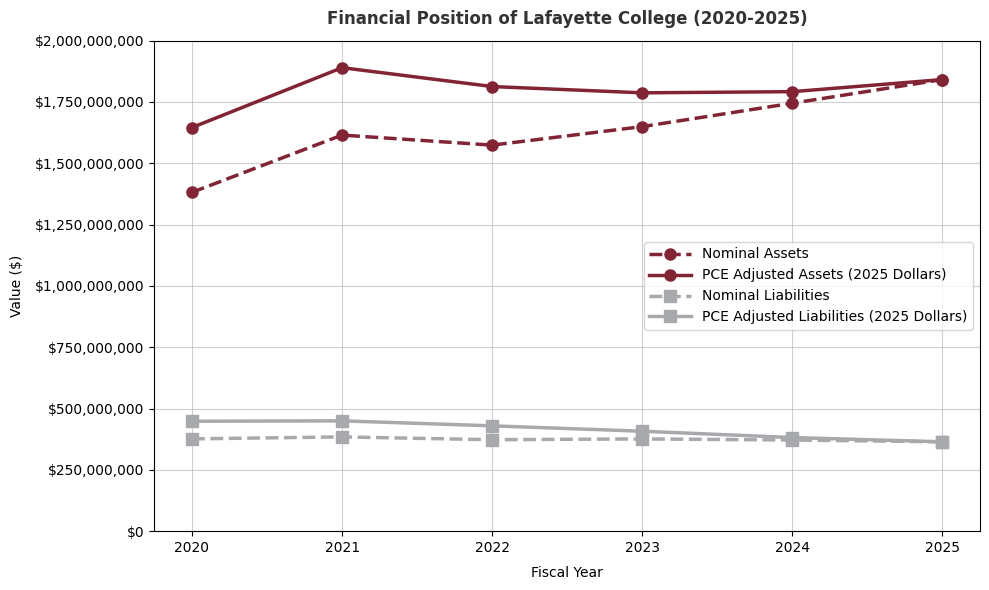

In [266]:
plt.figure(figsize=(10,6))

# plot assets over time
plt.plot(laf_annual_assets['year'], laf_annual_assets['value'], marker='o', markersize='8', linewidth=2.5, linestyle='--', color=MAROON, label='Nominal Assets')
plt.plot(laf_annual_assets_adjusted['year'], laf_annual_assets_adjusted['value'], marker='o', markersize='8', linewidth=2.5, linestyle='-', color=MAROON, label='PCE Adjusted Assets (2025 Dollars)')

# plot liabilities over time
plt.plot(laf_annual_liabilities['year'], laf_annual_liabilities['value'], marker='s', markersize='8', linewidth=2.5, linestyle='--', color=GREY, label='Nominal Liabilities')
plt.plot(laf_annual_liabilities_adjusted['year'], laf_annual_liabilities_adjusted['value'], marker='s', markersize='8', linewidth=2.5, linestyle='-', color=GREY, label='PCE Adjusted Liabilities (2025 Dollars)')

# legend and formatting
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
plt.title('Financial Position of Lafayette College (2020-2025)', fontsize=12, fontweight='bold', pad=12, color='#333333')
plt.xlabel('Fiscal Year', fontsize=10, labelpad=8)
plt.ylabel('Value ($)', fontsize=10, labelpad=8)
plt.ylim(0, 2_000_000_000) # set y range for ease of interpretation
plt.legend(loc='best', handlelength=3)
plt.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()

plt.show()

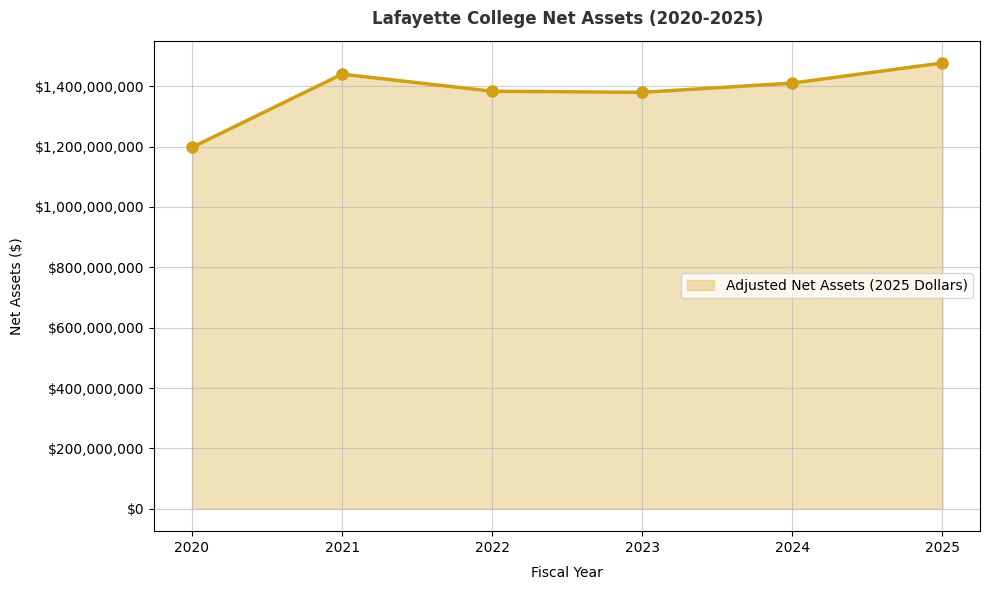

In [267]:
# calculate net assets
laf_annual_net_assets_adjusted = pd.DataFrame({
    'year': laf_annual_assets_adjusted['year'],
    'value': laf_annual_assets_adjusted['value'] - laf_annual_liabilities_adjusted['value']
})

# plot net assets with fill
plt.figure(figsize=(10,6))

plt.fill_between(laf_annual_net_assets_adjusted['year'], 0, laf_annual_net_assets_adjusted['value'], 
                 alpha=0.3, color=GOLD, label='Adjusted Net Assets (2025 Dollars)')
plt.plot(laf_annual_net_assets_adjusted['year'], laf_annual_net_assets_adjusted['value'], 
         marker='o', markersize='8', linewidth=2.5, linestyle='-', color=GOLD)

# formatting
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
plt.title('Lafayette College Net Assets (2020-2025)', fontsize=12, fontweight='bold', pad=12, color='#333333')
plt.xlabel('Fiscal Year', fontsize=10, labelpad=8)
plt.ylabel('Net Assets ($)', fontsize=10, labelpad=8)
plt.legend(loc='right')
plt.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()

plt.show()

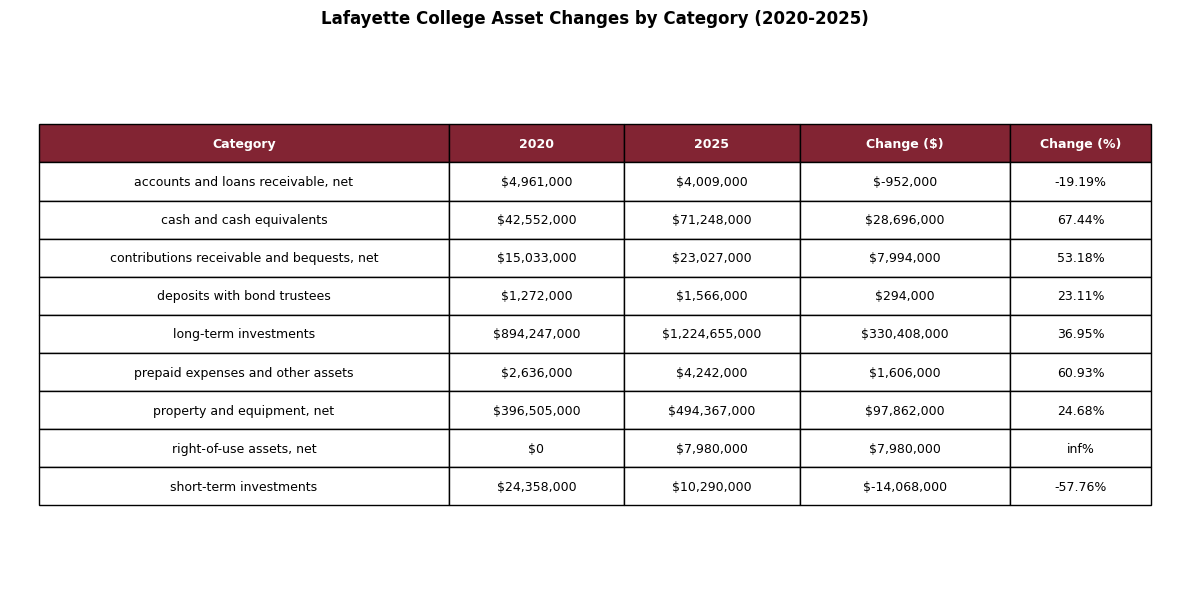

In [ ]:
# TODO: try visualizing this as a bar plot
# TODO: fix right of use assets, net. Why was this category added?

# calculate asset changes by category
laf_assets_2020 = laf_assets_df[laf_assets_df['year'] == 2020].groupby('category')['value'].sum()
laf_assets_2025 = laf_assets_df[laf_assets_df['year'] == 2025].groupby('category')['value'].sum()

# create a dataframe for the table
asset_changes = pd.DataFrame({
    '2020': laf_assets_2020,
    '2025': laf_assets_2025
})
asset_changes = asset_changes.fillna(0)  # replace NaN with 0
asset_changes['Change ($)'] = asset_changes['2025'] - asset_changes['2020']
asset_changes['Change (%)'] = ((asset_changes['2025'] - asset_changes['2020']) / asset_changes['2020'] * 100).round(2)

# create figure and plot table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# format
table_data = []
table_data.append(['Category', '2020', '2025', 'Change ($)', 'Change (%)'])
for idx, row in asset_changes.iterrows():
    change_pct = "N/A" if np.isinf(row['Change (%)']) else f"{row['Change (%)']:.2f}%"

    table_data.append([
        idx,
        f"${row['2020']:,.0f}",
        f"${row['2025']:,.0f}",
        f"${row['Change ($)']:,.0f}",
        f"{row['Change (%)']:.2f}%"
    ])

table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.18, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_facecolor(MAROON)
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Lafayette College Asset Changes by Category (2020-2025)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [269]:
total_assets_2020 = laf_assets_df[laf_assets_df['year'] == 2020]['value'].sum()
total_assets_2025 = laf_assets_df[laf_assets_df['year'] == 2025]['value'].sum()

total_change_value = total_assets_2025 - total_assets_2020
total_change_pct = (total_change_value / total_assets_2020 * 100)

print(f"Total Assets 2020: ${total_assets_2020:,.0f}")
print(f"Total Assets 2025: ${total_assets_2025:,.0f}")
print(f"Change ($): ${total_change_value:,.0f}")
print(f"Change (%): {total_change_pct:.2f}%")

Total Assets 2020: $1,381,564,000
Total Assets 2025: $1,841,384,000
Change ($): $459,820,000
Change (%): 33.28%


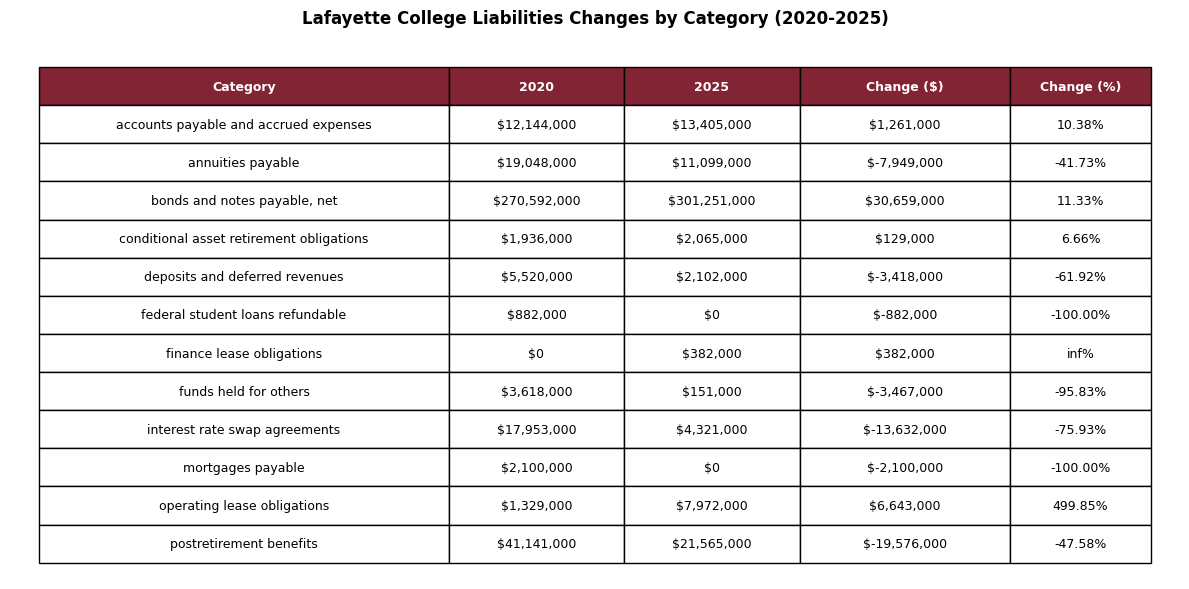

In [ ]:
# TODO: Fix the problem of certain categories not existing in certain financial statements and hence appearing as 0 in table. Whether mortgages payable was just included in bonds payable for example

# calculate asset changes by category
laf_liabilities_2020 = laf_liabilities_df[laf_liabilities_df['year'] == 2020].groupby('category')['value'].sum()
laf_liabilities_2025 = laf_liabilities_df[laf_liabilities_df['year'] == 2025].groupby('category')['value'].sum()

# create a dataframe for the table
liabilities_changes = pd.DataFrame({
    '2020': laf_liabilities_2020,
    '2025': laf_liabilities_2025
})
liabilities_changes = liabilities_changes.fillna(0)  # replace NaN with 0
liabilities_changes['Change ($)'] = liabilities_changes['2025'] - liabilities_changes['2020']
liabilities_changes['Change (%)'] = ((liabilities_changes['2025'] - liabilities_changes['2020']) / liabilities_changes['2020'] * 100).round(2)

# create figure and plot table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# format
table_data = []
table_data.append(['Category', '2020', '2025', 'Change ($)', 'Change (%)'])
for idx, row in liabilities_changes.iterrows():
    change_pct = "N/A" if np.isinf(row['Change (%)']) else f"{row['Change (%)']:.2f}%"

    table_data.append([
        idx,
        f"${row['2020']:,.0f}",
        f"${row['2025']:,.0f}",
        f"${row['Change ($)']:,.0f}",
        f"{row['Change (%)']:.2f}%"
    ])

table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.18, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_facecolor(MAROON)
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Lafayette College Liabilities Changes by Category (2020-2025)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [271]:
total_liabilities_2020 = laf_liabilities_df[laf_liabilities_df['year'] == 2020]['value'].sum()
total_liabilities_2025 = laf_liabilities_df[laf_liabilities_df['year'] == 2025]['value'].sum()

total_change_value = total_liabilities_2025 - total_liabilities_2020
total_change_pct = (total_change_value / total_liabilities_2020 * 100)

print(f"Total Assets 2020: ${total_liabilities_2020:,.0f}")
print(f"Total Assets 2025: ${total_liabilities_2025:,.0f}")
print(f"Change ($): ${total_change_value:,.0f}")
print(f"Change (%): {total_change_pct:.2f}%")

Total Assets 2020: $376,263,000
Total Assets 2025: $364,313,000
Change ($): $-11,950,000
Change (%): -3.18%


# Activities Analysis

# Cash Flows Analysis